In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

Загружаем данные с помощью метода read_csv библиотеки pandas. В этом наборе данных для 118 микрочипов (объекты) указаны результаты двух тестов по контролю качества (два числовых признака) и сказано, пустили ли микрочип в производство. Признаки уже центрированы, то есть из всех значений вычтены средние по столбцам. Таким образом, "среднему" микрочипу соответствуют нулевые значения результатов тестов.

In [3]:
df = pd.read_csv('data/microchip_tests.txt', header=None, 
                 names=('test1', 'test2', 'released'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
released    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


In [4]:
df.head()

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [5]:
df.tail()

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


In [8]:
X = df.ix[:, :2].values
y = df.ix[:, 2].values

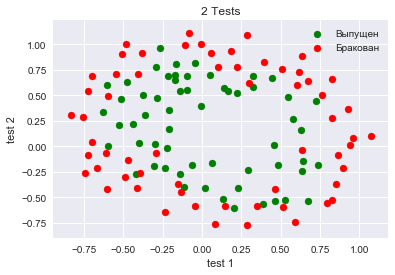

In [12]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel('test 1')
plt.ylabel('test 2')

plt.title('2 Tests')
plt.legend()

Определяем функцию для отображения разделяющей кривой классификатора

In [38]:
def plt_bound(clf, X, y, grid_step=.01, poly_feature=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step), np.arange(y_min, y_max, grid_step))
    
    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в соответствие свой цвет
    z = clf.predict(poly_feature.transform(np.c_[xx.ravel(), yy.ravel()]))
    z = z.reshape(xx.shape)
    plt.contour(xx, yy, z, cmap=plt.cm.Paired)

In [39]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

C = 1e-2
# N-jobs = -1 = all CPU cores
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)

logit.fit(X_poly, y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

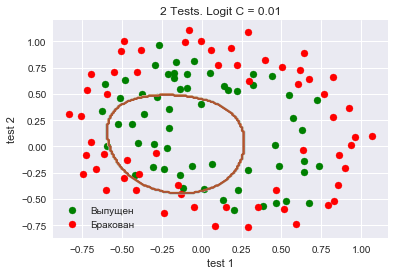

In [41]:
plt_bound(logit, X, y, grid_step=.01, poly_feature=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel('test 1')
plt.ylabel('test 2')

plt.title('2 Tests. Logit C = 0.01')
plt.legend()

In [42]:
print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

Доля правильных ответов классификатора на обучающей выборке: 0.627


Увеличим C до 1. Тем самым мы ослабляем регуляризацию, теперь в решении значения весов логистической регрессии могут оказаться больше (по модулю), чем в прошлом случае.

Доля правильных ответов классификатора на обучающей выборке: 0.831


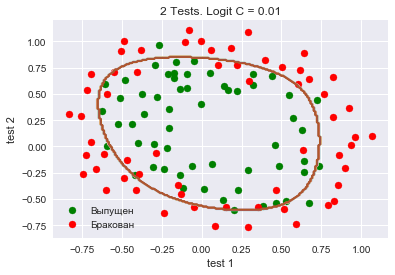

In [45]:
C = 1
# N-jobs = -1 = all CPU cores
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)

logit.fit(X_poly, y)
plt_bound(logit, X, y, grid_step=.01, poly_feature=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel('test 1')
plt.ylabel('test 2')

plt.title('2 Tests. Logit C = 0.01')
plt.legend()
print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

Доля правильных ответов классификатора на обучающей выборке: 0.873


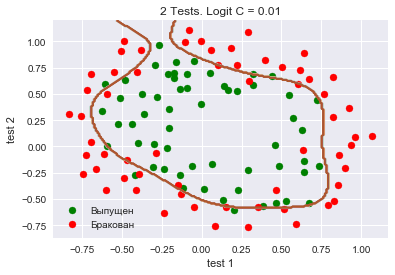

In [46]:
C = 1e4
# N-jobs = -1 = all CPU cores
logit = LogisticRegression(C=C, n_jobs=-1, random_state=17)

logit.fit(X_poly, y)
plt_bound(logit, X, y, grid_step=.01, poly_feature=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='green', label='Выпущен')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Бракован')
plt.xlabel('test 1')
plt.ylabel('test 2')

plt.title('2 Tests. Logit C = 0.01')
plt.legend()
print("Доля правильных ответов классификатора на обучающей выборке:", 
round(logit.score(X_poly, y), 3))

**Промежуточные выводы:**

* чем больше параметр C, тем более сложные зависимости в данных может восстанавливать модель (интуитивно C соответствует "сложности" модели (model capacity))
* если регуляризация слишком сильная (малые значения C), то решением задачи минимизации логистической функции потерь может оказаться то, когда многие веса занулились или стали слишком малыми. Еще говорят, что модель недостаточно "штрафуется" за ошибки (то есть в функционале J "перевешивает" сумма квадратов весов, а ошибка L может быть относительно большой). В таком случае модель окажется недообученной (1 случай)
* наоборот, если регуляризация слишком слабая (большие значения C), то решением задачи оптимизации может стать вектор w с большими по модулю компонентами. В таком случае больший вклад в оптимизируемый функционал J имеет L и, вольно выражаясь, модель слишком "боится" ошибиться на объектах обучающей выборки, поэтому окажется переобученной (3 случай)
* то, какое значение C выбрать, сама логистическая регрессия "не поймет" (или еще говорят "не выучит"), то есть это не может быть определено решением оптимизационной задачи, которой является логистическая регрессия (в отличие от весов w). Так же точно, дерево решений не может "само понять", какое ограничение на глубину выбрать (за один процесс обучения). Поэтому C – это гиперпараметр модели, который настраивается на кросс-валидации, как и max_depth для дерева.

## Cross validation

Теперь найдем оптимальное (в данном примере) значение параметра регуляризации C. Сделать это можно с помощью LogisticRegressionCV – перебора параметров по сетке с последующей кросс-валидацией. Этот класс создан специально для логистической регрессии (для нее известны эффективные алгоритмы перебора параметров), для произвольной модели мы бы использовали GridSearchCV, RandomizedSearchCV или, например, специальные алгоритмы оптимизации гиперпараметров, реализованные в hyperopt.

In [56]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
c_values = np.logspace(-2, 3, 500)

logit_searcher = LogisticRegressionCV(Cs=c_values, cv=skf, n_jobs=-1)
logit_searcher.fit(X_poly, y)

LogisticRegressionCV(Cs=array([  1.00000e-02,   1.02334e-02, ...,   9.77192e+02,   1.00000e+03]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='ovr', n_jobs=-1, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

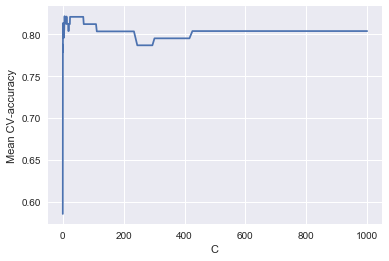

In [58]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy')

(0, 10)

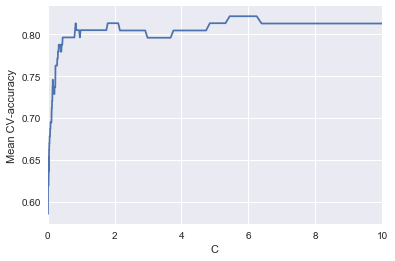

In [59]:
plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
plt.xlabel('C')
plt.ylabel('Mean CV-accuracy')
plt.xlim((0,10))